In [ ]:
from transformers import BertModel, BertTokenizerFast
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from transformers import BertModel, BertTokenizerFast
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.multiclass import unique_labels
import pandas as pd
import numpy as np
import os

In [ ]:
# Load the dataset
data = pd.read_csv('/home/naamamai/translated_distinct_records_final_version.csv')
test = pd.read_csv('segments_with_intents.csv')
prompting = pd.read_csv('/home/naamamai/final_prompts.csv')

data = data[['transcript_hebrew', 'intent']]
print(data.head())

merged_data = pd.concat([data, prompting], ignore_index=True)
print(len(merged_data))

# Apply filter (update the condition based on your needs)
# Example: Filter rows where the 'intent' column matches Siri intents
filter_condition = merged_data['intent'].isin([
    'calendar_set', 'calendar_query', 'weather_query', 'play_music', 'play_audiobook',
    'play_radio', 'email_query', 'sendemail', 'alarm_query', 'alarm_set',
    'datetime_query', 'social_post', 'qa_factoid', 'general_query', 'news_query', 'query', 'send_message', 'transport_query', 'camera_query', 'qa_currency', 'convert', 'lists_createoradd', 'iot_wemo_on', 'general', 'call_contact'
])

filtered_data = merged_data[filter_condition]

# Stop execution if no rows match the filter
if filtered_data.empty:
    raise ValueError("Filtered dataset is empty. No matching rows found with the given condition.")

# Display filtered data (optional)
print(filtered_data.head())
print(len(filtered_data))

                                   transcript_hebrew           intent
0                           אני צריך שתקבעי לי אירוע     calendar_set
1  אני צריך שתקבעי לי אירוע מתוכנן בעוד שלושה ימי...     calendar_set
2                        אני צריך שתגבירי את הווליום  audio_volume_up
3                    אני צריכה שתוריד קצת את הבהירות  iot_hue_lightup
4                 אני רוצה לדעת מה מזג האוויר הנוכחי    weather_query
12442
                                   transcript_hebrew         intent
0                           אני צריך שתקבעי לי אירוע   calendar_set
1  אני צריך שתקבעי לי אירוע מתוכנן בעוד שלושה ימי...   calendar_set
4                 אני רוצה לדעת מה מזג האוויר הנוכחי  weather_query
8  עיין בדוא"ל שלי להודעות דוא"ל חדשות במהלך השעה...    email_query
9                תשימי לי שעון מעורר לשבע וחצי בבוקר      alarm_set
6917


In [ ]:
data = filtered_data

In [ ]:
le = LabelEncoder()
data['intent_num'] = le.fit_transform(data['intent'])
map_intent = dict(zip(le.transform(le.classes_), le.classes_))
map_intent

{0: 'alarm_query',
 1: 'alarm_set',
 2: 'calendar_query',
 3: 'calendar_set',
 4: 'call_contact',
 5: 'camera_query',
 6: 'convert',
 7: 'datetime_query',
 8: 'email_query',
 9: 'general',
 10: 'iot_wemo_on',
 11: 'lists_createoradd',
 12: 'news_query',
 13: 'play_audiobook',
 14: 'play_music',
 15: 'play_radio',
 16: 'qa_currency',
 17: 'qa_factoid',
 18: 'query',
 19: 'send_message',
 20: 'sendemail',
 21: 'social_post',
 22: 'transport_query',
 23: 'weather_query'}

In [ ]:
input = list(data['transcript_hebrew'])
input

['אני צריך שתקבעי לי אירוע',
 'אני צריך שתקבעי לי אירוע מתוכנן בעוד שלושה ימים עם איימי',
 'אני רוצה לדעת מה מזג האוויר הנוכחי',
 'עיין בדוא"ל שלי להודעות דוא"ל חדשות במהלך השעה האחרונה',
 'תשימי לי שעון מעורר לשבע וחצי בבוקר',
 'את יכולה להראות לי את השעונים המתוכננים?',
 'אני רוצה שתזכירי לי את הפגישה הבאה עם חברה שלי בשעה שמונה אחר הצהריים ביום ראשון הבא',
 'אני רוצה שתנגני את רשימת ההשמעה טקטיקות מאפליקציית מוזיקה',
 'תבדקי לי מה מזג האוויר',
 "את יכולה לבדוק מתי אני אמור להיפגש פעם הבאה עם ג'ו?",
 'אנא הזכירי לי על פגישת עסקים באחת עשרה בבוקר',
 'אנא תציג לי את השעון המעורר שקבעת לפגישה של יום שלישי',
 'האם אני צריך ללבוש בגדים חמים היום?',
 'תאונת רכבת',
 'האם יש לי תזכורות צפויות',
 'פייסבוק משיקה תג שנוי במחלוקת כדי לפצח חדשות מזויפות',
 'הורד אוצר מילים מסוים',
 'האם תוכל בבקשה ליצור אירוע חדש בלוח השנה שלי',
 'תראה לי את כל האימיילים האחרונים מאנה',
 'הפעל את ספר השמע',
 'ספר לי את הפגישות שלי ביום רביעי בבוקר',
 'קבע שעון מעורר ליום חמישי בשעה שבע אחר הצהריים',
 'הוסף פגישה 

In [ ]:
model_name = 'onlplab/alephbert-base'
model = BertModel.from_pretrained('onlplab/alephbert-base')
tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
#Tokenize and pad the texts
encoded_inputs = tokenizer(input, padding=True,
                            truncation=True,
                            return_tensors='pt')


Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
with torch.no_grad():
  outputs = model(**encoded_inputs)

In [ ]:
# the embedding of the first sentnce with alephbert
outputs[0]

tensor([[[ 0.5784, -0.2647,  0.2294,  ...,  0.1198,  0.6145,  0.3198],
         [ 1.8840, -0.9533, -0.4049,  ...,  1.1754,  0.9827,  0.1392],
         [-0.0300, -0.6815, -0.6953,  ..., -0.0499,  0.9928, -0.4141],
         ...,
         [ 1.1545,  0.2843, -1.4542,  ...,  1.2382,  1.6651,  0.9464],
         [ 1.0593,  0.2974, -1.4815,  ...,  1.3169,  1.6171,  0.9027],
         [ 1.0667,  0.3622, -1.3765,  ...,  1.3134,  1.7715,  0.9589]],

        [[-0.1972,  0.1200,  0.6063,  ..., -0.3229,  0.4015, -0.0302],
         [ 0.8978, -0.6201, -0.2589,  ...,  0.9188,  1.3150,  0.0089],
         [-0.3857, -0.6432, -0.4828,  ..., -0.5043,  0.8859, -0.5987],
         ...,
         [ 1.2392,  0.8134, -0.1882,  ...,  0.0482,  2.0180,  0.6676],
         [ 1.2440,  0.6693,  0.0124,  ...,  0.0913,  1.9969,  0.6181],
         [ 1.2716,  1.0713, -0.0169,  ..., -0.2618,  1.7758,  0.8206]],

        [[ 0.2413, -0.3162, -0.7478,  ..., -0.2921,  0.5574, -0.0961],
         [ 1.6164, -0.7688, -0.0265,  ...,  0

In [ ]:
token_embeddings = outputs.last_hidden_state

In [ ]:
sentence_embeddings = []
for embedding in token_embeddings:
  sentence_embeddings.append(embedding.flatten().numpy())

In [ ]:
sentence_embeddings = np.array(sentence_embeddings)

In [ ]:
labels = list(data['intent_num'])

In [ ]:
input_test = list(test['transcript_hebrew'])
encoded_inputs_test = tokenizer(input_test, padding=True,
                            truncation=True,
                            return_tensors='pt')
with torch.no_grad():
  outputs_test = model(**encoded_inputs_test)

token_embeddings_test = outputs_test.last_hidden_state
sentence_embeddings_test = []
for embedding in token_embeddings_test:
    sentence_embeddings_test.append(embedding.flatten().numpy())

sentence_embeddings_test = np.array(sentence_embeddings_test)

intent_to_num = {v: k for k, v in map_intent.items()}

# Map the 'intent' column in the test data to 'intent_num'
test['intent_num'] = test['intent'].map(intent_to_num)

# Check the result
print(test[['intent', 'intent_num']].head())

labels_test = list(test['intent_num'])

print(labels_test)
test



            intent  intent_num
0  transport_query          22
1     call_contact           4
2        alarm_set           1
3     send_message          19
4            query          18
[22, 4, 1, 19, 18, 18, 18, 18, 18, 18, 3, 3, 3, 3, 3, 3, 1, 14, 14, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 16, 16, 16, 23, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 11, 10, 10, 22, 22, 4, 4, 1, 19, 19, 19, 19, 18, 18, 22, 22, 22, 22, 22, 22, 22, 22, 3, 1, 1, 1, 1, 14, 5, 16, 16, 23, 6, 7, 11, 11, 9, 10, 10, 22, 22, 22, 4, 4, 1, 19, 18, 18, 22, 22, 3, 1, 14, 14, 5, 5, 5, 5, 5, 16, 23, 6, 7, 11, 11, 11, 11, 11, 10, 10, 22, 4, 4, 1, 1, 19, 18, 22, 22, 22, 22, 22, 22, 18, 1, 1, 1, 1, 14, 14, 14, 5, 16, 22, 23, 6, 6, 6, 6, 7, 7, 11, 10, 10, 10]


,transcript_hebrew,intent,intent_num
0,היי סירי את יכולה למצוא לי מסלול מהמיקום שלי ...,transport_query,22
1,היי סירי את יכולה לחייג לקורל יגוד,call_contact,4
2,היי סירי את יכולה לכוון שעון מעורר לשמונה וחצ...,alarm_set,1
3,היי סירי את יכולה לשלוח הודעה לקורל יגוד,send_message,19
4,היי סירי את יכולה לחפש לי מתכון לעוגה באסקית,query,18
...,...,...,...
143,מה השעה בניו יורק מה השעה בניו יורק מה השעה הכ...,datetime_query,7
144,אני רוצה לרשום קניות חלב וביצים אם תוכלי לעזור לי,lists_createoradd,11
145,כי אני רוצה להפעיל מצב טיסה,iot_wemo_on,10
146,אני רוצה להפעיל מצב טיסה בסדר,iot_wemo_on,10


In [ ]:
# Convert labels and labels_test to pandas Series
labels_series = pd.Series(labels)
labels_test_series = pd.Series(labels_test)

# Concatenate the Series objects
final_labels = pd.concat([labels_series, labels_test_series], ignore_index=True)
print(len(final_labels))

# Ensure the labels match the total embeddings (train + test split already done)
assert len(final_labels) == len(sentence_embeddings) + len(sentence_embeddings_test), "Labels must match embeddings."

# Split labels to create y_train and y_test
y_train = labels
y_test = labels_test

# Assign embeddings to X_train and X_test
X_train = sentence_embeddings
X_test = sentence_embeddings_test

# Check the shapes to ensure correct splitting
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

7065
X_train shape: (6917, 27648)
X_test shape: (148, 15360)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Ensure consistent dimensions between X_train and X_test
if X_train.shape[1] != X_test.shape[1]:
    print("Aligning features...")
    # Example: Truncate or pad X_test to match X_train's feature size
    if X_train.shape[1] > X_test.shape[1]:
        diff = X_train.shape[1] - X_test.shape[1]
        X_test = np.pad(X_test, ((0, 0), (0, diff)), mode='constant')
    elif X_train.shape[1] < X_test.shape[1]:
        X_test = X_test[:, :X_train.shape[1]]

# Verify shapes
print(f"Updated X_train shape: {X_train.shape}")
print(f"Updated X_test shape: {X_test.shape}")
print(X_test[:5])
print(y_test[:5])


Aligning features...
Updated X_train shape: (6917, 27648)
Updated X_test shape: (148, 27648)
[[-0.9575888  -0.3014761   0.6865433  ...  0.          0.
   0.        ]
 [-0.58377457 -0.8928134   0.2345633  ...  0.          0.
   0.        ]
 [-0.9152402  -0.23704451 -0.1019947  ...  0.          0.
   0.        ]
 [-0.11804873 -0.24845614 -0.3065499  ...  0.          0.
   0.        ]
 [-0.83265275 -0.04300927 -0.4834312  ...  0.          0.
   0.        ]]
[22, 4, 1, 19, 18]


transfer learning with fine-tuning using a pre-trained BERT model (onlplab/alephbert-base)

In [ ]:
from transformers import BertModel, BertTokenizerFast, AdamW
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Define custom BERT model for intent classification
class BertForIntentClassification(torch.nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertForIntentClassification, self).__init__()
        self.bert = bert_model
        self.classifier = torch.nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = self.classifier(cls_output)
        return logits

# Initialize the model
num_classes = len(map_intent)
fine_tuned_model = BertForIntentClassification(model, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tuned_model.to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(fine_tuned_model.parameters(), lr=2e-5)

# Prepare data loaders
batch_size = 16

# Prepare data loaders
train_data = torch.utils.data.TensorDataset(
    torch.tensor(encoded_inputs['input_ids'], dtype=torch.long),
    torch.tensor(encoded_inputs['attention_mask'], dtype=torch.long),
    torch.tensor(labels, dtype=torch.long)
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = torch.utils.data.TensorDataset(
    torch.tensor(encoded_inputs_test['input_ids'], dtype=torch.long),
    torch.tensor(encoded_inputs_test['attention_mask'], dtype=torch.long),
    torch.tensor(labels_test, dtype=torch.long)
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [ ]:
# Training loop with Early Stopping
fine_tuned_model.train()

best_loss = float('inf')
patience = 10
early_stop_counter = 0

epochs = 50

for epoch in range(epochs):
    total_loss = 0
    fine_tuned_model.train()

    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        outputs = fine_tuned_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_loss:.4f}")


    # Validation
    fine_tuned_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = fine_tuned_model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        early_stop_counter = 0
        # Optionally save the best model
        torch.save(fine_tuned_model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter} epochs. Patience left: {patience - early_stop_counter}")

    if early_stop_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Load the best model if saved
fine_tuned_model.load_state_dict(torch.load("best_model.pth"))

# Evaluation loop
fine_tuned_model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = fine_tuned_model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

present_classes = unique_labels(true_labels, predictions)
present_class_names = [map_intent[i] for i in present_classes]

print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=present_class_names))

Epoch 1/50, Training Loss: 0.6582
Epoch 1/50, Validation Loss: 0.8130
Epoch 2/50, Training Loss: 0.1940
Epoch 2/50, Validation Loss: 1.1372
No improvement for 1 epochs. Patience left: 9
Epoch 3/50, Training Loss: 0.1064
Epoch 3/50, Validation Loss: 0.8822
No improvement for 2 epochs. Patience left: 8
Epoch 4/50, Training Loss: 0.0654
Epoch 4/50, Validation Loss: 0.7847
Epoch 5/50, Training Loss: 0.0531
Epoch 5/50, Validation Loss: 1.1426
No improvement for 1 epochs. Patience left: 9
Epoch 6/50, Training Loss: 0.0478
Epoch 6/50, Validation Loss: 1.4287
No improvement for 2 epochs. Patience left: 8
Epoch 7/50, Training Loss: 0.0389
Epoch 7/50, Validation Loss: 1.0257
No improvement for 3 epochs. Patience left: 7
Epoch 8/50, Training Loss: 0.0390
Epoch 8/50, Validation Loss: 1.3371
No improvement for 4 epochs. Patience left: 6
Epoch 9/50, Training Loss: 0.0333
Epoch 9/50, Validation Loss: 1.1295
No improvement for 5 epochs. Patience left: 5
Epoch 10/50, Training Loss: 0.0325
Epoch 10/50, 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 1/50, Training Loss: 0.0376
Epoch 1/50, Validation Loss: 1.2555
Epoch 2/50, Training Loss: 0.0316
Epoch 2/50, Validation Loss: 1.1481
Epoch 3/50, Training Loss: 0.0311
Epoch 3/50, Validation Loss: 1.5318
No improvement for 1 epochs. Patience left: 9
Epoch 4/50, Training Loss: 0.0367
Epoch 4/50, Validation Loss: 1.6740
No improvement for 2 epochs. Patience left: 8
Epoch 5/50, Training Loss: 0.0203
Epoch 5/50, Validation Loss: 1.5402
No improvement for 3 epochs. Patience left: 7
Epoch 6/50, Training Loss: 0.0202
Epoch 6/50, Validation Loss: 1.8017
No improvement for 4 epochs. Patience left: 6
Epoch 7/50, Training Loss: 0.0181
Epoch 7/50, Validation Loss: 1.6784
No improvement for 5 epochs. Patience left: 5
Epoch 8/50, Training Loss: 0.0366
Epoch 8/50, Validation Loss: 1.6804
No improvement for 6 epochs. Patience left: 4
Epoch 9/50, Training Loss: 0.0190
Epoch 9/50, Validation Loss: 1.5694
No improvement for 7 epochs. Patience left: 3
Epoch 10/50, Training Loss: 0.0137
Epoch 10/50, 

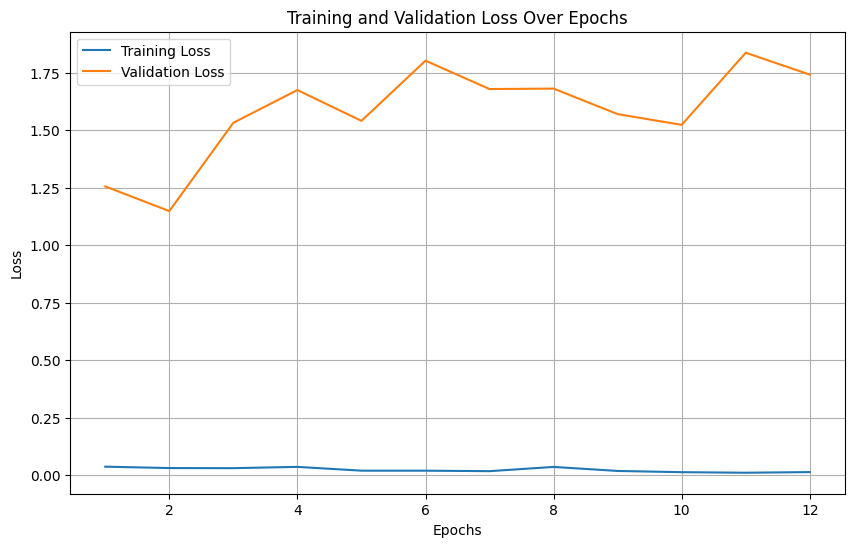

True Positive Examples by Class:

alarm_query:

alarm_set:
  -  היי סירי את יכולה לכוון שעון מעורר לשמונה וחצי בערב
  - אני רוצה שתפעיל לי שעון מעורר להיום בערב בשעה שמונה וחצי
  - סירי תכווני לי שעון מעורר לשש וחצי בבוקר
  - סירי תתריאי לי עוד שעתיים לקחת תרופה
  - תכווני לי את השעון מעורר

calendar_query:

calendar_set:
  -  היי סירי את יכולה להוסיף לי פגישה ביומן בחמישי לחמישי בשעה חמש וחצי תור לרופא
  - סירי תרשמי לי בלוח שנה פגישה בחמישי לחמישי בשעה חמש וחצי תור לרופא
  - תרשמי ביומן בלוח שנה בחמישי לחמישי עשרים וחמש תור לרופא בשעה חמש וחצי
  - סירי תרשמי לי פגישה ביומן בחמישי לחמישי עשרים וחמש בשעה חמש וחצי תור לרופא
  -  היי סירי את יכולה לרשום לי ביומן פגישה בחמישי למאי 25 בשעה חמש וחצי  תור לרופא

call_contact:
  - תתקשרי בבקשה לקורל יגוד
  - תתקשרי בבקשה לסתיו ברק
  - סירי תתקשרי לדביר
  - תתקשרי אותי לקורל
  - אני רוצה להתקשר לקורל בבקשה ממך

camera_query:
  - תפתחי לי את המצלמה עם מצלמה קדמית
  - תהפכי את המצלמה למצלמה קדמית
  - תסובבי לי את המצלמה
  - תפתחי את המצלמה עם מצ

In [ ]:
import matplotlib.pyplot as plt

# Training loop with Early Stopping
fine_tuned_model.train()

best_loss = float('inf')
patience = 10
early_stop_counter = 0

epochs = 50
train_losses = []
val_losses = []

# Create a dictionary to store true positive examples for each class
true_positive_examples = {class_id: [] for class_id in map_intent.keys()}

for epoch in range(epochs):
    total_loss = 0
    fine_tuned_model.train()

    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        outputs = fine_tuned_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_loss:.4f}")


    # Validation
    fine_tuned_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = fine_tuned_model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        early_stop_counter = 0
        # Optionally save the best model
        torch.save(fine_tuned_model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter} epochs. Patience left: {patience - early_stop_counter}")

    if early_stop_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Load the best model if saved
fine_tuned_model.load_state_dict(torch.load("best_model.pth"))

# Evaluation loop
fine_tuned_model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = fine_tuned_model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Collect true positive examples
for i, (true, pred) in enumerate(zip(true_labels, predictions)):
    if true == pred:
        intent_name = map_intent[true]
        true_positive_examples[true].append(test.iloc[i]['transcript_hebrew'])

# Print true positive examples
print("True Positive Examples by Class:")
for class_id, examples in true_positive_examples.items():
    class_name = map_intent[class_id]
    print(f"\n{class_name}:")
    for example in examples[:5]:  # Limit to 5 examples per class for readability
        print(f"  - {example}")

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

present_classes = unique_labels(true_labels, predictions)
present_class_names = [map_intent[i] for i in present_classes]

print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=present_class_names))
